In [14]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 128
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor()
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [15]:
# https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=fHvQjMkcm_FK
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances: (B * patch size * patch size, num embedding * embedding size)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
        
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # get minimum distnace embedding index
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten: [0, 0, ..., 1, 0] * num embedding -> only get minimum embedding features from lookup table
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss # using detach(), stop gradient was implemented
        e_latent_loss = F.mse_loss(quantized.detach(), inputs) # Z_e 가 e 에 가깝도록
        q_latent_loss = F.mse_loss(quantized, inputs.detach()) # e 가 Z_e 에 가깝도록
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [16]:
# # https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb#scrollTo=fHvQjMkcm_FK
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)


    def forward(self, x):
        x = F.relu(self._conv_1(x))        
        x = F.relu(self._conv_2(x))
        x = self._conv_3(x)

        return x
    
    
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, out_channels=1):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=out_channels,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self._conv_1(x))
        x = F.relu(self._conv_trans_1(x))
        x = F.tanh(self._conv_trans_2(x))

        return x
    

class VQVAE(nn.Module):
    def __init__(self, num_hiddens, num_embeddings, embedding_dim, commitment_cost, in_channels=1):
        super().__init__()
        self._encoder = Encoder(in_channels, num_hiddens)
        
        # 이건 flatten한 후에 FC layer 가능
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        
        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self._decoder = Decoder(embedding_dim, num_hiddens, out_channels=in_channels)

        
    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [17]:
class VectorQuantizedVAE(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    
    def forward(self, x):
        return self.model(x)

        
    def predict(self, x):
        _, recon_image, _ = self(x)

        return recon_image
    
    
    def step(self, batch):
        imgs, _ = batch
        vq_loss, recon_image, perplexity = self(imgs)
        
        recon_loss = F.mse_loss(recon_image, imgs)
        total_loss = recon_loss + vq_loss
        
        return total_loss
    
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
        return optimizer


callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=3, dirpath='weights/VQVAE', filename='VQVAE-{epoch:03d}-{valid_loss:.4f}'),
]


num_hiddens = 128
embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25

model = VQVAE(num_hiddens, num_embeddings, embedding_dim, commitment_cost)
vqvae = VectorQuantizedVAE(model)
trainer = pl.Trainer(gpus=[1], max_epochs=10, enable_progress_bar=True, callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
# trainer.fit(vqvae, train_dataloader, valid_dataloader)

In [19]:
import random

idx = list(range(len(test_data.data)))
random.shuffle(idx)
idx = idx[:16]
test_samples = test_data.data[idx].unsqueeze(1).float()

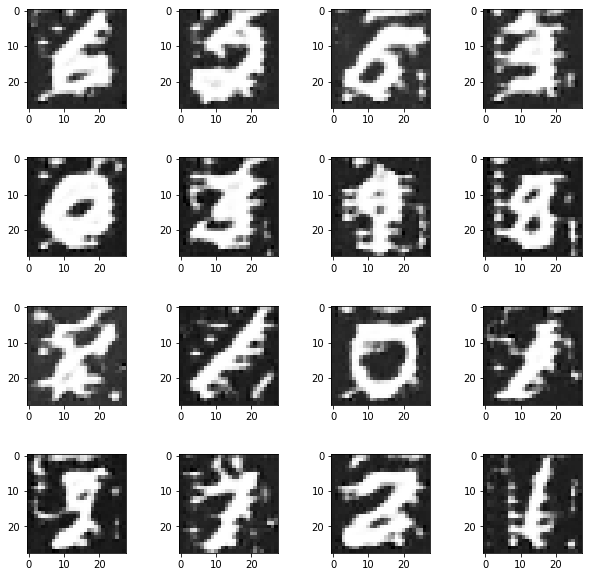

In [20]:
ckpt_fname = "VQVAE-epoch=008-valid_loss=0.0079.ckpt"
vqvae = vqvae.load_from_checkpoint("weights/VQVAE/" + ckpt_fname, model=model)
vqvae.model.eval()

samples = vqvae.predict(test_samples)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()